In [473]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3080 (UUID: GPU-36022ad1-3b01-52a9-f671-0142eff32f72)


In [474]:
import sys
print(f"Python {sys.version}")

Python 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]


In [475]:
import tensorflow as tf

print(f"TensorFlow {tf.__version__}")
print(f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )

gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
    print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

TensorFlow 2.7.0
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


In [476]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [477]:
raw_df = pd.read_csv("./heart.csv")
raw_df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [490]:
raw_df.shape

(303, 14)

In [478]:
x_raw = raw_df.drop(columns="output").to_numpy()
scaler = StandardScaler().fit(x_raw)
x_raw = scaler.transform(x_raw)

y_raw = raw_df['output'].to_numpy()

X_train,X_test,y_train,y_test=train_test_split(x_raw,y_raw,test_size=0.3,random_state=88)
X_train,X_test,y_train,y_test = X_train,X_test,y_train,y_test


In [479]:
np.random.seed(88)
tf.random.set_seed(88)

In [480]:
input_dim = X_train.shape[1]
output_dim = 1

print(f'Input Dimension: {input_dim}\nOutput Dimension: {output_dim}')

Input Dimension: 13
Output Dimension: 1


In [481]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

In [482]:
model = tf.keras.models.Sequential()

model.add(tf.keras.Input(shape=(input_dim,)))

model.add(tf.keras.layers.Dense(512, activation='relu', name='hidden1'))
model.add(tf.keras.layers.BatchNormalization(axis=1, name='bn1'))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Dense(output_dim, activation='sigmoid', name="output"))

model.summary()


Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden1 (Dense)             (None, 512)               7168      
                                                                 
 bn1 (BatchNormalization)    (None, 512)               2048      
                                                                 
 dropout_30 (Dropout)        (None, 512)               0         
                                                                 
 output (Dense)              (None, 1)                 513       
                                                                 
Total params: 9,729
Trainable params: 8,705
Non-trainable params: 1,024
_________________________________________________________________


In [483]:
model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate = 0.001), 
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                metrics=['acc']
                )

In [484]:
checkpoint_filepath = "bestmodel_epoch{epoch:02d}_valloss{val_loss:.2f}.hdf5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                                save_weights_only=True,
                                                                monitor='val_acc',
                                                                mode='max',
                                                                save_best_only=True)

In [485]:
history = model.fit(X_train, y_train, batch_size=256, epochs=1000, verbose=1, validation_split=0.2, callbacks=[model_checkpoint_callback])

Epoch 1/1000
1/1 [==============================] - 0s 352ms/step - loss: 0.9410 - acc: 0.5444 - val_loss: 0.6702 - val_acc: 0.6512
Epoch 2/1000
1/1 [==============================] - 0s 24ms/step - loss: 0.7197 - acc: 0.6450 - val_loss: 0.6456 - val_acc: 0.7209
Epoch 3/1000
1/1 [==============================] - 0s 17ms/step - loss: 0.5892 - acc: 0.7219 - val_loss: 0.6266 - val_acc: 0.7209
Epoch 4/1000
1/1 [==============================] - 0s 25ms/step - loss: 0.5065 - acc: 0.7633 - val_loss: 0.6114 - val_acc: 0.7907
Epoch 5/1000
1/1 [==============================] - 0s 23ms/step - loss: 0.4719 - acc: 0.7278 - val_loss: 0.5986 - val_acc: 0.8372
Epoch 6/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.3804 - acc: 0.8225 - val_loss: 0.5882 - val_acc: 0.8372
Epoch 7/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.3978 - acc: 0.8284 - val_loss: 0.5796 - val_acc: 0.8372
Epoch 8/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.3477 - 

In [486]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

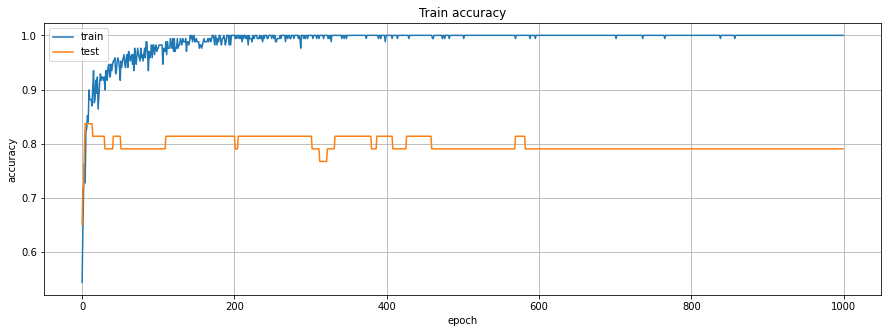

In [487]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

In [488]:
results = model.evaluate(X_test, y_test, batch_size = 128)
print(f"{model.metrics_names} = {results}")

1/1 [==============================] - 0s 16ms/step - loss: 0.9800 - acc: 0.8462
['loss', 'acc'] = [0.9799714088439941, 0.8461538553237915]
